# Microsft Bing Image Search Download

Using Microsoft Bing to download images of different foods.

Source: https://docs.microsoft.com/en-us/azure/cognitive-services/bing-image-search/quickstarts/python

**Note:** The docs link above says to use `"https://api.cognitive.microsoft.com/bing/v7.0/images/search"` as the search API URL but due to API changes, the correct link to use is `"https://api.bing.microsoft.com/v7.0/images/search"`. This is true for API instances made after October 30, 2020.

In [110]:
# Append the upper level directory to sys
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

from pathlib import Path

# Get config
from configs.default_config import config

args = config
GS_BUCKET = args.gs_bucket_name
# print(args)

# Connect to GCP
from utils.gcp_utils import set_gcp_credentials, test_gcp_connection
set_gcp_credentials(path_to_key="../utils/google-storage-key.json")
test_gcp_connection()

import wandb

# Initialize a new run
from utils.wandb_utils import wandb_load_artifact, wandb_download_and_load_labels

notes = f"add images downloaded from Bing to the dataset"

run = wandb.init(project=args.wandb_project, 
                 job_type=args.wandb_job_type,
                 tags=['manual_photo_upload'],
                 notes=notes)

annotations, class_names, class_dict, reverse_class_dict, labels_path = wandb_download_and_load_labels(wandb_run=run,
wandb_labels_artifact_name=args.wandb_labels_artifact)

print(f"Number of unique items in original labels: {len(annotations.label.unique())}")

# Make a copy of the annotations
original_annotations = annotations.copy()

# Get the columns of the annotations
columns_to_create = list(original_annotations.columns)
columns_to_create

[INFO] GCP credentials set!
[INFO] GCP connection successful! Access to GCP for saving/loading data and models available.


[INFO] Labels directory: ./artifacts/food_vision_labels:v71
[INFO] Labels path: artifacts/food_vision_labels:v71/annotations.csv
[INFO] Working with: 309 classes
Number of unique items in original labels: 309


['filename',
 'image_name',
 'class_name',
 'label',
 'split',
 'clear_or_confusing',
 'whole_food_or_dish',
 'one_food_or_multiple',
 'label_last_updated_at',
 'label_source',
 'image_source']

In [111]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# TODO: change this to an environment variable
# Read in the API key from a file
with open("../utils/bing_image_search_api_key.txt", "r") as f:
    subscription_key = f.read()

# search_url = "https://api.cognitive.microsoft.com/bing/v7.0/images/search" # OLD
search_url = "https://api.bing.microsoft.com/v7.0/images/search" # New (after Oct 30, 2020)


In [112]:
headers = {"Ocp-Apim-Subscription-Key" : subscription_key}

## Create and send a search request

In [113]:
search_term = "rice cake"

# See list of params here - https://docs.microsoft.com/en-us/bing/search-apis/bing-image-search/reference/query-parameters 
params = {
    "q": search_term,
    "license": "All",
    "imageType": "photo"
}

In [114]:
response = requests.get(search_url, headers=headers, params=params)
response.raise_for_status() # used for debugging
search_results = response.json()

# Get first 16 thumbnail URLs
thumbnail_urls = [img["thumbnailUrl"] for img in search_results["value"][:16]]

In [115]:
search_results

{'_type': 'Images',
 'instrumentation': {'_type': 'ResponseInstrumentation'},
 'readLink': 'images/search?q=rice cake',
 'webSearchUrl': 'https://www.bing.com/images/search?q=rice cake&FORM=OIIARP',
 'queryContext': {'originalQuery': 'rice cake',
  'alterationDisplayQuery': 'rice cakes',
  'alterationOverrideQuery': '+rice cake',
  'alterationMethod': 'AM_JustChangeIt',
  'alterationType': 'CombinedAlterationsChained'},
 'totalEstimatedMatches': 360,
 'nextOffset': 41,
 'currentOffset': 0,
 'value': [{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=rice+cake&id=9BE71BC1F3D885997D2743715F46E8C2A7D63C1E&simid=608024072314904464',
   'name': 'Low-FODMAP & Low-Fructose Ideas for Rice Cakes - Delicious as it Looks',
   'thumbnailUrl': 'https://tse4.mm.bing.net/th?id=OIP.ex-p4lY1eYVHLoovvX346AHaE7&pid=Api',
   'datePublished': '2020-06-22T17:24:00.0000000Z',
   'isFamilyFriendly': True,
   'contentUrl': 'http://2.bp.blogspot.com/-lNOklmwICok/UZVZTFyLUUI/AAAAAA

In [116]:
# The length of "value" parameter will be set by the "count" parameter:
# see: https://docs.microsoft.com/en-us/bing/search-apis/bing-image-search/reference/query-parameters
# Min: 35, Max: 150
len(search_results["value"])

35

In [117]:
search_results["value"][0]

{'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=rice+cake&id=9BE71BC1F3D885997D2743715F46E8C2A7D63C1E&simid=608024072314904464',
 'name': 'Low-FODMAP & Low-Fructose Ideas for Rice Cakes - Delicious as it Looks',
 'thumbnailUrl': 'https://tse4.mm.bing.net/th?id=OIP.ex-p4lY1eYVHLoovvX346AHaE7&pid=Api',
 'datePublished': '2020-06-22T17:24:00.0000000Z',
 'isFamilyFriendly': True,
 'contentUrl': 'http://2.bp.blogspot.com/-lNOklmwICok/UZVZTFyLUUI/AAAAAAAAD0s/N1UYCcmLo4w/s1600/050+rice+cake+pbj.jpg',
 'hostPageUrl': 'https://deliciousasitlooks.com/2013/05/low-fodmap-ideas-for-rice-cakes.html',
 'contentSize': '191763 B',
 'encodingFormat': 'jpeg',
 'hostPageDisplayUrl': 'https://deliciousasitlooks.com/2013/05/low-fodmap-ideas-for-rice-cakes.html',
 'width': 1600,
 'height': 1066,
 'hostPageDiscoveredDate': '2018-11-09T00:00:00.0000000Z',
 'thumbnail': {'width': 474, 'height': 315},
 'imageInsightsToken': 'ccid_ex+p4lY1*cp_CB2A0E69DED2F21A8204F0EE884F4707*mid_9

In [118]:
# We can save metadata from our image so we can look it up later
attributes_from_value = ["width", "height", "contentURL"] 
attributes_to_create = ["date_created", "source"]

In [119]:
# Get current time
import datetime
current_time = datetime.datetime.now().strftime(
                "%Y-%m-%d %H:%M:%S"
            )
current_time

'2023-03-22 13:33:06'

## View images

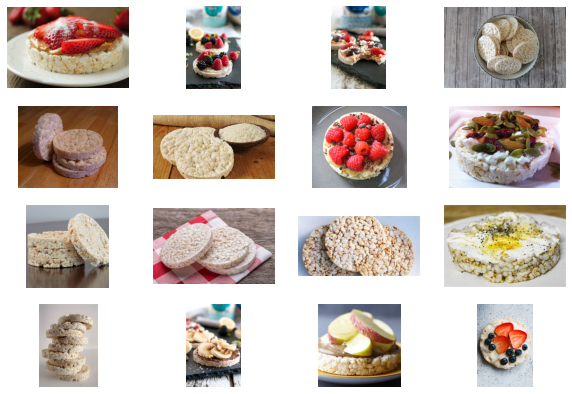

In [120]:
fig, axes = plt.subplots(4, 4, figsize=(10, 7))
for i in range(4):
    for j in range (4):
        image_data = requests.get(thumbnail_urls[i+4*j]) # downloads as bytes
        image_data.raise_for_status()
        image = Image.open(BytesIO(image_data.content))
        axes[i][j].imshow(image)
        axes[i][j].axis("off")
plt.show()

## Downloading an image

In [121]:
# image = requests.get("https://pixnio.com/free-images/2017/11/10/2017-11-10-21-27-56.jpg")
# open("downloaded_img.jpg", "wb").write(image.content)

## Getting URLs for multiple images (for different search terms)

Let's write some code to get a bunch of images downloaded (we can turn the following into a script later).

In [122]:
# TODO: Create search terms
# Make this a programmatic way to download images for those images without 100+ images
# E.g. import annotations and labels and then read them in and download images for each label


In [123]:
import requests
import matplotlib.pyplot as plt
import streamlit as st

from PIL import Image
from io import BytesIO

API_KEY = subscription_key
SEARCH_URL = "https://api.bing.microsoft.com/v7.0/images/search"

# Number of images per page
COUNT = 150 # min 35, max 150, see "count" - https://docs.microsoft.com/en-us/bing/search-apis/bing-image-search/reference/query-parameters

headers = {"Ocp-Apim-Subscription-Key" : API_KEY}

# TODO
* Batch save images
* Batch delete images
* Add image metadata to CSV (for logging and exporting later)

In [124]:
# Find classes in annotations with less than X samples
min_num_samples = 100
classes_to_download = annotations.class_name.value_counts()[annotations.class_name.value_counts() < min_num_samples].index.tolist()

# Import metadata
import json
with open("food_class_metadata_dicts.json", "r") as f:
    food_metadata = json.load(f)

# Map classes_to_download to display_name in food_metadata
classes_to_download_updated_names = []
for class_name in classes_to_download:
    for food_item in food_metadata:
        if class_name == food_item["nutrify_name"]:
            class_to_download_dict = {}
            class_to_download_dict["display_name"] = food_item["display_name"].lower().replace(" ", "_")
            class_to_download_dict["nutrify_name"] = food_item["nutrify_name"]
            class_to_download_dict["search_term"] = food_item["display_name"].lower().replace(" ", "_")
            classes_to_download_updated_names.append(class_to_download_dict)

classes_to_download_updated_names

[]

In [70]:
# Create a mapping of search terms to be replaced
replace_terms = {"white_sweet_potato": "okinawan_purple_sweet_potato",
                 "candy_melon": "orange_candy_melon",
                 "pattypan_squash": "sunburst_squash",
                 "chicory": "chicory_bunch",
                 "sugar_plum": "sugar_plum_fruit",
                "beef_kebab": "beef_skewers",
                "chives_(garlic)": "garlic_chives_bunch",
                "rocket": "rocket_leaf",
                "sage": "sage_herb",
                "pepper_(black)": "black_pepper",
                "tarragon": "fresh_tarragon"}

# Add a key called "search_terms" to each class_to_download_dict
for class_to_download_dict in classes_to_download_updated_names:
    if class_to_download_dict["display_name"] in replace_terms.keys():
        class_to_download_dict["search_term"] = replace_terms[class_to_download_dict["display_name"]]

classes_to_download_updated_names

[{'display_name': 'butternut_pumpkin',
  'nutrify_name': 'pumpkin_butternut',
  'search_term': 'butternut_pumpkin'},
 {'display_name': 'red_potato',
  'nutrify_name': 'potato_red',
  'search_term': 'red_potato'},
 {'display_name': 'green_cabbage',
  'nutrify_name': 'cabbage_green',
  'search_term': 'green_cabbage'},
 {'display_name': 'white_rice',
  'nutrify_name': 'rice_white',
  'search_term': 'white_rice'},
 {'display_name': 'pattypan_squash',
  'nutrify_name': 'squash_pattypan',
  'search_term': 'sunburst_squash'},
 {'display_name': 'naan_bread',
  'nutrify_name': 'bread_naan',
  'search_term': 'naan_bread'},
 {'display_name': 'chicken_curry',
  'nutrify_name': 'curry_chicken',
  'search_term': 'chicken_curry'},
 {'display_name': 'brown_swiss_mushroom',
  'nutrify_name': 'mushroom_swiss_brown',
  'search_term': 'brown_swiss_mushroom'},
 {'display_name': 'brown_rice',
  'nutrify_name': 'rice_brown',
  'search_term': 'brown_rice'},
 {'display_name': 'prosciutto',
  'nutrify_name': 'p

In [71]:
extra_terms = []
search_terms = [item["search_term"] for item in classes_to_download_updated_names]
search_terms.extend(extra_terms)
search_terms = sorted(search_terms)

print(search_terms)

['beef_patty', 'beef_skewers', 'bitter_melon', 'black_pepper', 'brown_rice', 'brown_swiss_mushroom', 'butternut_pumpkin', 'chicken_burger', 'chicken_curry', 'chicken_stir-fry', 'chicory_bunch', 'cocoa_powder', 'custard_apple', 'diced_beef', 'dill', 'dino_melon', 'flat_mushrooms', 'fresh_tarragon', 'fruit_salad', 'fruit_smoothie', 'garlic_chives_bunch', 'green_cabbage', 'ice', 'jalapeño', 'kipfler_potato', 'marjoram', 'milkshake', 'naan_bread', 'okinawan_purple_sweet_potato', 'orange_candy_melon', 'oregano', 'peanuts', 'pomelo', 'prosciutto', 'purple_carrot', 'purple_sweet_potato', 'rambutan', 'red_oakleaf_lettuce', 'red_potato', 'rocket_leaf', 'sage_herb', 'silverbeet', 'spaghetti_squash', 'spanish_melon', 'sugar_plum_fruit', 'sunburst_squash', 'thyme', 'toasted_sandwich', 'tuna', 'turmeric', 'white_rice', 'wombok']


In [42]:
import uuid
from tqdm.auto import tqdm
img_to_download_list = []

for search_term in tqdm(search_terms):

    search_term = search_term.replace("_", " ")

    print(f"\n[INFO] Searching for '{search_term}' images...")
    params = {
        "q": search_term,
        "license": "all",
        "imageType": "photo",
        "count": COUNT
    }
    
    response = requests.get(SEARCH_URL, 
                            headers=headers, 
                            params=params)
    response.raise_for_status() # used for debugging
    search_results = response.json()

    print(f"[INFO] Found {search_results['totalEstimatedMatches']} potential image matches...")
    print("[INFO] Appending image URLs to dictionary... \n")
    for i, value in enumerate(search_results["value"]):
        img_metadata = {}

        # Give each image a UUID
        img_metadata["image_id"] = str(uuid.uuid4())

        # State the source of the image
        img_metadata["source"] = "microsoft_bing_image_search_api_v7"
        
        # Collect metadata about each image
        img_metadata["search_term"] = search_term
        img_metadata["img_url"] = value["contentUrl"]
        img_metadata["height"] = value["height"]
        img_metadata["width"] = value["width"]
        img_metadata["time_downloaded"] = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        img_to_download_list.append(img_metadata)
        if i % 100 == 0:
            print(f"[INFO] Adding image url for '{search_term}': {img_metadata['img_url']}...")
            print(f"[INFO] Total images to download in list: {len(img_to_download_list)}")

  0%|          | 0/52 [00:00<?, ?it/s]


[INFO] Searching for 'beef skewers' images...
[INFO] Found 373 potential image matches...
[INFO] Appending image URLs to dictionary... 

[INFO] Adding image url for 'beef skewers': https://amandacooksandstyles.com/wp-content/uploads/2021/03/20210328_170842-1040x1536.jpg...
[INFO] Total images to download in list: 1
[INFO] Adding image url for 'beef skewers': https://www.manilaspoon.com/wp-content/uploads/2013/05/BeefKafta-2887-1440x2017.jpg...
[INFO] Total images to download in list: 101

[INFO] Searching for 'beef patty' images...
[INFO] Found 365 potential image matches...
[INFO] Appending image URLs to dictionary... 

[INFO] Adding image url for 'beef patty': http://iheartrecipes.com/wp-content/uploads/2014/03/IMG_2825.jpg...
[INFO] Total images to download in list: 151
[INFO] Adding image url for 'beef patty': https://i1.wp.com/comboplate.net/wp-content/uploads/2018/12/Patties-ED.jpg?fit=1200%2C798&ssl=1...
[INFO] Total images to download in list: 251

[INFO] Searching for 'bitter

In [43]:
# Preview images to download
img_to_download_list[:3]

[{'image_id': 'b46f8a40-d3ad-42b2-a5ed-71a81a0b709c',
  'source': 'microsoft_bing_image_search_api_v7',
  'search_term': 'beef skewers',
  'img_url': 'https://amandacooksandstyles.com/wp-content/uploads/2021/03/20210328_170842-1040x1536.jpg',
  'height': 1536,
  'width': 1040,
  'time_downloaded': '2023-03-22 09:21:34'},
 {'image_id': 'e027b27c-041d-4d13-acc5-67f9095cec55',
  'source': 'microsoft_bing_image_search_api_v7',
  'search_term': 'beef skewers',
  'img_url': 'https://diethood.com/wp-content/uploads/2017/01/Beef_Skewers.jpg',
  'height': 960,
  'width': 640,
  'time_downloaded': '2023-03-22 09:21:34'},
 {'image_id': 'f6f459da-7cf0-4937-8fd8-57d72a78161a',
  'source': 'microsoft_bing_image_search_api_v7',
  'search_term': 'beef skewers',
  'img_url': 'https://cdn.shortpixel.ai/client/q_lossy,ret_img,w_732/https://tatyanaseverydayfood.com/wp-content/uploads/2017/08/Teriyaki-Beef-Skewers-4-732x1024.jpg',
  'height': 1024,
  'width': 732,
  'time_downloaded': '2023-03-22 09:21:34'

In [44]:
# Put a check here to see if any of the images are already downloaded
# If they are, remove them from the targ_img_df list

# Download file from GCP of all images already downloaded
# Go through the file of downloaded images
# If the image is in the combined_results list, remove it from the list
import os
from utils.gcp_utils import get_list_of_blobs, download_blobs_to_file

check_for_images_already_downloaded = True

target_dir_for_list_of_existing_downloads = "bing_image_search_downloads"

if check_for_images_already_downloaded:
    # Check for files in GCP
    blobs = get_list_of_blobs(bucket_name=GS_BUCKET,
                              prefix=target_dir_for_list_of_existing_downloads)
    print(blobs)

    download_blobs_to_file(blobs=blobs,
                           destination_dir=target_dir_for_list_of_existing_downloads)
    
    # Get a file list of all the files in the target_dir_for_list_of_existing_downloads
    downloaded_files = os.listdir(target_dir_for_list_of_existing_downloads)

    # Make sure all the files in downloaded_files end with .csv
    downloaded_files = [file for file in downloaded_files if file.endswith(".csv")]

    # Read each of the downloaded_files into a dataframe
    import pandas as pd
    downloaded_files_dfs = []
    for file in downloaded_files:
        downloaded_files_dfs.append(pd.read_csv(f"{target_dir_for_list_of_existing_downloads}/{file}"))
    
    # Concatenate all the dataframes into one
    downloaded_files_df = pd.concat(downloaded_files_dfs)

    # Remove duplicates
    downloaded_files_df = downloaded_files_df.drop_duplicates(subset="img_url")

    print(f"[INFO] Number of images already downloaded: {len(downloaded_files_df)}")

[<Blob: food_vision_bucket_with_object_versioning, bing_image_search_downloads/2023-03-21_08-22-59_list_of_foods_to_download.csv, 1679366911714509>, <Blob: food_vision_bucket_with_object_versioning, bing_image_search_downloads/2023-03-21_10-06-20_list_of_foods_to_download.csv, 1679366912241430>, <Blob: food_vision_bucket_with_object_versioning, bing_image_search_downloads/2023-03-21_12-59-12_list_of_foods_to_download_from_bing.csv, 1679367869585279>]
[INFO] Downloading bing_image_search_downloads/2023-03-21_08-22-59_list_of_foods_to_download.csv to bing_image_search_downloads/2023-03-21_08-22-59_list_of_foods_to_download.csv
[INFO] Downloading bing_image_search_downloads/2023-03-21_10-06-20_list_of_foods_to_download.csv to bing_image_search_downloads/2023-03-21_10-06-20_list_of_foods_to_download.csv
[INFO] Downloading bing_image_search_downloads/2023-03-21_12-59-12_list_of_foods_to_download_from_bing.csv to bing_image_search_downloads/2023-03-21_12-59-12_list_of_foods_to_download_from_

In [45]:
len(downloaded_files_df)

750

In [47]:
# Turn the list of images to download into a dataframe
import pandas as pd
img_to_download_df = pd.DataFrame(img_to_download_list)

# Remove duplicates
img_to_download_df = img_to_download_df.drop_duplicates(subset="img_url")

# Print length before removing existing images
print(f"[INFO] Number of images to download: {len(img_to_download_df)}")

# Remove images that have already been downloaded
img_to_download_df = img_to_download_df[~img_to_download_df["img_url"].isin(downloaded_files_df["img_url"])]
img_to_download_df = img_to_download_df.reset_index(drop=True)

# Print length after removing existing images
print(f"[INFO] Number of images to download: {len(img_to_download_df)} (after removing existing image URLs)")

# Turn the dataframe into a list of dictionaries
img_to_download_list = img_to_download_df.to_dict("records")


[INFO] Number of images to download: 7748
[INFO] Number of images to download: 7748 (after removing existing image URLs)


In [49]:
# If there are no images to download, exit the program
num_images_to_download = len(img_to_download_list)
if num_images_to_download == 0:
    print("[INFO] No new image URLs to download, exiting program...")
    # sys.exit()
else:
    print(f"[INFO] Number of new images to download: {num_images_to_download}")
    # Get current timestamp
    from utils.misc import get_now_time
    from pathlib import Path
    now = get_now_time()

    # Make a directory called "data_downloaded_from_bing"
    import os
    dir_to_save_to = target_dir_for_list_of_existing_downloads
    if not os.path.exists(dir_to_save_to):
        os.makedirs(dir_to_save_to)

    # Save the targ_img_df to a csv
    save_path = Path(f"{dir_to_save_to}/{now}_list_of_foods_to_download_from_bing.csv")
    targ_img_df = pd.DataFrame(img_to_download_list)
    targ_img_df.to_csv(save_path)

    # Upload to GCP
    from utils.gcp_utils import upload_to_gs

    upload_to_gs(bucket_name=GS_BUCKET,
                source_file_name=str(save_path),
                destination_blob_name=str(save_path))


[INFO] Number of new images to download: 7748
[INFO] Uploading bing_image_search_downloads/2023-03-22_09-26-36_list_of_foods_to_download_from_bing.csv to bing_image_search_downloads/2023-03-22_09-26-36_list_of_foods_to_download_from_bing.csv...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File bing_image_search_downloads/2023-03-22_09-26-36_list_of_foods_to_download_from_bing.csv uploaded to food_vision_bucket_with_object_versioning/bing_image_search_downloads/2023-03-22_09-26-36_list_of_foods_to_download_from_bing.csv.
[INFO] File size: 1625362 bytes


In [50]:
targ_img_df = pd.DataFrame(img_to_download_list)
targ_img_df.head()

,image_id,source,search_term,img_url,height,width,time_downloaded
0,b46f8a40-d3ad-42b2-a5ed-71a81a0b709c,microsoft_bing_image_search_api_v7,beef skewers,https://amandacooksandstyles.com/wp-content/up...,1536,1040,2023-03-22 09:21:34
1,e027b27c-041d-4d13-acc5-67f9095cec55,microsoft_bing_image_search_api_v7,beef skewers,https://diethood.com/wp-content/uploads/2017/0...,960,640,2023-03-22 09:21:34
2,f6f459da-7cf0-4937-8fd8-57d72a78161a,microsoft_bing_image_search_api_v7,beef skewers,"https://cdn.shortpixel.ai/client/q_lossy,ret_i...",1024,732,2023-03-22 09:21:34
3,e93770b7-8ccf-4a2b-be43-980f8a311536,microsoft_bing_image_search_api_v7,beef skewers,https://therecipecritic.com/wp-content/uploads...,710,474,2023-03-22 09:21:34
4,fd08b77d-5cea-470a-98de-c3d294a9ec60,microsoft_bing_image_search_api_v7,beef skewers,https://www.barbequick.com/recipes/wp-content/...,2740,1600,2023-03-22 09:21:34


## Downloading data for multiple URLs

Now we have a bunch of URLs, let's download data.

In [53]:
search_terms

['beef_skewers',
 'beef_patty',
 'bitter_melon',
 'brown_rice',
 'brown_swiss_mushroom',
 'butternut_pumpkin',
 'orange_candy_melon',
 'chicken_burger',
 'chicken_curry',
 'chicken_stir-fry',
 'chicory_bunch',
 'garlic_chives_bunch',
 'cocoa_powder',
 'custard_apple',
 'diced_beef',
 'dill',
 'dino_melon',
 'flat_mushrooms',
 'fruit_salad',
 'fruit_smoothie',
 'green_cabbage',
 'ice',
 'jalapeño',
 'kipfler_potato',
 'marjoram',
 'milkshake',
 'naan_bread',
 'oregano',
 'sunburst_squash',
 'peanuts',
 'black_pepper',
 'pomelo',
 'prosciutto',
 'purple_carrot',
 'purple_sweet_potato',
 'rambutan',
 'red_oakleaf_lettuce',
 'red_potato',
 'rocket_leaf',
 'sage_herb',
 'silverbeet',
 'spaghetti_squash',
 'spanish_melon',
 'sugar_plum_fruit',
 'fresh_tarragon',
 'thyme',
 'toasted_sandwich',
 'tuna',
 'turmeric',
 'white_rice',
 'okinawan_purple_sweet_potato',
 'wombok']

In [54]:
# List of exceptions, source: https://www.pyimagesearch.com/2018/04/09/how-to-quickly-build-a-deep-learning-image-dataset/
from requests import exceptions
EXCEPTIONS = set([IOError, FileNotFoundError,
	exceptions.RequestException, exceptions.HTTPError,
	exceptions.ConnectionError, exceptions.Timeout])

In [56]:
img_to_download_list[0], len(img_to_download_list)

({'image_id': 'b46f8a40-d3ad-42b2-a5ed-71a81a0b709c',
  'source': 'microsoft_bing_image_search_api_v7',
  'search_term': 'beef skewers',
  'img_url': 'https://amandacooksandstyles.com/wp-content/uploads/2021/03/20210328_170842-1040x1536.jpg',
  'height': 1536,
  'width': 1040,
  'time_downloaded': '2023-03-22 09:21:34'},
 7748)

## Download images

In [73]:
# Get a mapping of search_terms to nutrify_name
search_term_to_nutrify_name = {}
for search_term in search_terms:
    for item in classes_to_download_updated_names:
        if item["search_term"] == search_term:
            search_term_to_nutrify_name[search_term] = item["nutrify_name"]
            
search_term_to_nutrify_name

{'beef_patty': 'beef_patty',
 'beef_skewers': 'beef_kebab',
 'bitter_melon': 'melon_bitter',
 'black_pepper': 'black_pepper',
 'brown_rice': 'rice_brown',
 'brown_swiss_mushroom': 'mushroom_swiss_brown',
 'butternut_pumpkin': 'pumpkin_butternut',
 'chicken_burger': 'chicken_burger',
 'chicken_curry': 'curry_chicken',
 'chicken_stir-fry': 'chicken_stir_fry',
 'chicory_bunch': 'chicory',
 'cocoa_powder': 'cocoa_powder',
 'custard_apple': 'apple_custard',
 'diced_beef': 'beef_diced',
 'dill': 'dill',
 'dino_melon': 'melon_dino',
 'flat_mushrooms': 'mushroom_flat',
 'fresh_tarragon': 'tarragon',
 'fruit_salad': 'fruit_salad',
 'fruit_smoothie': 'fruit_smoothie',
 'garlic_chives_bunch': 'garlic_chives',
 'green_cabbage': 'cabbage_green',
 'ice': 'ice',
 'jalapeño': 'jalapeno',
 'kipfler_potato': 'potato_kipfler',
 'marjoram': 'marjoram',
 'milkshake': 'milkshake',
 'naan_bread': 'bread_naan',
 'okinawan_purple_sweet_potato': 'potato_white_sweet',
 'orange_candy_melon': 'melon_candy',
 'oreg

In [77]:
import os
import uuid
from tqdm.auto import tqdm

TARG_DIR = f"{get_now_time()}-food_images_from_bing"

if not os.path.exists(TARG_DIR):
    print(f"[INFO] Making directory: {TARG_DIR}...")
    os.makedirs(TARG_DIR, exist_ok=True)
else:
    print(f"[INFO] Directory '{TARG_DIR}' exists, skipping creation...")

# Make target dirs
for search_term in search_terms:
    # Map search_term to nutrify_name
    search_term = search_term_to_nutrify_name[search_term]
    print(f"Making directory: {search_term}")
    os.makedirs(os.path.join(TARG_DIR, search_term), exist_ok=True)

# Download images...
print(f"\n[INFO] Attempting to download {len(img_to_download_list)} images...\n")
for i, img_dict in tqdm(enumerate(img_to_download_list), total=len(img_to_download_list)):
    img_id = img_dict["image_id"]
    img_url = img_dict["img_url"]
    search_term = img_dict["search_term"]
    search_term = search_term.replace(" ", "_")
    # Map search_term to nutrify_name
    search_term = search_term_to_nutrify_name[search_term]
    try:
        # Get the image
        img_data = requests.get(img_url, timeout=30)

        # Write image to file
        class_dir = os.path.join(TARG_DIR, search_term)
        save_path = os.path.join(class_dir, 
                                 img_id + ".jpg")
        f = open(save_path, "wb")
        f.write(img_data.content)
        f.close()
    
    # If the image doesn't download, skip it 
    except Exception as e:
        if type(e) in EXCEPTIONS:
            print(f"\n[INFO] Skipping image: {img_url} due to exception: {e}\n")
            continue    

    if i % 50 == 0:
        print(f"[INFO] Images downloaded successfully for {search_term}: {len(os.listdir(class_dir))}")

[INFO] Making directory: 2023-03-22_09-54-44-food_images_from_bing...
Making directory: beef_patty
Making directory: beef_kebab
Making directory: melon_bitter
Making directory: black_pepper
Making directory: rice_brown
Making directory: mushroom_swiss_brown
Making directory: pumpkin_butternut
Making directory: chicken_burger
Making directory: curry_chicken
Making directory: chicken_stir_fry
Making directory: chicory
Making directory: cocoa_powder
Making directory: apple_custard
Making directory: beef_diced
Making directory: dill
Making directory: melon_dino
Making directory: mushroom_flat
Making directory: tarragon
Making directory: fruit_salad
Making directory: fruit_smoothie
Making directory: garlic_chives
Making directory: cabbage_green
Making directory: ice
Making directory: jalapeno
Making directory: potato_kipfler
Making directory: marjoram
Making directory: milkshake
Making directory: bread_naan
Making directory: potato_white_sweet
Making directory: melon_candy
Making directory:

  0%|          | 0/7748 [00:00<?, ?it/s]

[INFO] Images downloaded successfully for beef_kebab: 1
[INFO] Images downloaded successfully for beef_kebab: 51
[INFO] Images downloaded successfully for beef_kebab: 101
[INFO] Images downloaded successfully for beef_patty: 1
[INFO] Images downloaded successfully for beef_patty: 51

[INFO] Skipping image: https://www.cbc.ca/food/content/images/recipes/BeefPatties.jpg due to exception: ('Connection aborted.', HTTPException('got more than 100 headers'))

[INFO] Images downloaded successfully for beef_patty: 99
[INFO] Images downloaded successfully for melon_bitter: 1
[INFO] Images downloaded successfully for melon_bitter: 51
[INFO] Images downloaded successfully for melon_bitter: 101
[INFO] Images downloaded successfully for rice_brown: 1

[INFO] Skipping image: http://www.culicurious.com/wp-content/uploads/2012/11/Brown-Rice.jpg due to exception: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

[INFO] Images downloaded successfully for rice_brown: 50

[IN

2023-03-22 11:04:12.297 WARNING urllib3.connection: Certificate did not match expected hostname: healthessentials.co.za. Certificate: {'subject': ((('commonName', '*.cpt4.host-h.net'),),), 'issuer': ((('countryName', 'US'),), (('organizationName', 'DigiCert, Inc.'),), (('commonName', 'GeoTrust Global TLS RSA4096 SHA256 2022 CA1'),)), 'version': 3, 'serialNumber': '038524B7A228637BD61D9DE503832C6C', 'notBefore': 'Jun 20 00:00:00 2022 GMT', 'notAfter': 'Jul  9 23:59:59 2023 GMT', 'subjectAltName': (('DNS', '*.cpt4.host-h.net'), ('DNS', 'cpt4.host-h.net')), 'OCSP': ('http://ocsp.digicert.com',), 'caIssuers': ('http://cacerts.digicert.com/GeoTrustGlobalTLSRSA4096SHA2562022CA1.crt',), 'crlDistributionPoints': ('http://crl3.digicert.com/GeoTrustGlobalTLSRSA4096SHA2562022CA1.crl', 'http://crl4.digicert.com/GeoTrustGlobalTLSRSA4096SHA2562022CA1.crl')}


[INFO] Images downloaded successfully for cabbage_green: 1
[INFO] Images downloaded successfully for cabbage_green: 49
[INFO] Images downloaded successfully for cabbage_green: 99

[INFO] Skipping image: https://img1.mashed.com/img/gallery/the-real-difference-between-red-and-green-cabbage/intro-1588611813.jpg due to exception: HTTPSConnectionPool(host='img1.mashed.com', port=443): Max retries exceeded with url: /img/gallery/the-real-difference-between-red-and-green-cabbage/intro-1588611813.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7ff539bb99d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))

[INFO] Images downloaded successfully for ice: 1
[INFO] Images downloaded successfully for ice: 51
[INFO] Images downloaded successfully for ice: 101
[INFO] Images downloaded successfully for jalapeno: 1

[INFO] Skipping image: http://fundaciondelchile.com/wp-content/uploads/2016/07/jalapeno_03_chile-1024x1024.jpg due to except

2023-03-22 11:38:23.049 WARNING urllib3.connection: Certificate did not match expected hostname: img.yts.mx. Certificate: {'subject': ((('commonName', '*.carsalesnetwork.com.au'),),), 'issuer': ((('countryName', 'US'),), (('organizationName', 'Amazon'),), (('commonName', 'Amazon RSA 2048 M02'),)), 'version': 3, 'serialNumber': '0E4FC2EE12E30028076308F54E3D5960', 'notBefore': 'Feb 10 00:00:00 2023 GMT', 'notAfter': 'Sep 27 23:59:59 2023 GMT', 'subjectAltName': (('DNS', '*.carsalesnetwork.com.au'),), 'OCSP': ('http://ocsp.r2m02.amazontrust.com',), 'caIssuers': ('http://crt.r2m02.amazontrust.com/r2m02.cer',), 'crlDistributionPoints': ('http://crl.r2m02.amazontrust.com/r2m02.crl',)}


[INFO] Images downloaded successfully for peanuts: 92
[INFO] Images downloaded successfully for peanuts: 142

[INFO] Skipping image: https://spiceboutique.co.za/wp-content/uploads/2020/09/Black-Pepper-Whole.jpg due to exception: HTTPSConnectionPool(host='spiceboutique.co.za', port=443): Max retries exceeded with url: /wp-content/uploads/2020/09/Black-Pepper-Whole.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7ff539be65b0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))

[INFO] Images downloaded successfully for black_pepper: 42
[INFO] Images downloaded successfully for black_pepper: 91
[INFO] Images downloaded successfully for black_pepper: 140
[INFO] Images downloaded successfully for pomelo: 44

[INFO] Skipping image: https://img2.mashed.com/img/gallery/the-real-difference-between-pomelos-and-grapefruits/intro-1595950574.jpg due to exception: HTTPSConnectionPool(host='img2.mashed.com', port=443): Max retri

## TODO: Delete images that don't work

TODO:
* Scan through downloaded images and if they don't work, delete them.
    * See this for scanning through directories to get subpath names: https://stackoverflow.com/a/2909998/7900723
* Also delete them from the CSV metadata file.

```python
# Pseudocode
for img_path in img_paths:
    try:
        open(img_path)

    # If it doesn't open, delete the image...
    except:
        os.remove(img_path)
        # CODE HERE TO DELTE FROM CSV FILE AS WELL???
        continue
```

In [78]:
import os
import pathlib # see here for more on PathLib - https://realpython.com/python-pathlib/
img_files_to_check = []
for path, subdirs, files in os.walk(TARG_DIR):
    for name in files:
        # print(name.split(".")[0])
        img_files_to_check.append(pathlib.Path(path, name))


In [79]:
# .stem gets the filename from a PosixPath (Path datatype) 
img_files_to_check[0].stem

'b3a2c9c6-2c04-4694-873c-7d58b4d17c2e'

In [80]:
broken_images = []
for img_file_path in img_files_to_check:
    # Check images downloaded and delete if bogus
    try:
        image_id = img_file_path.stem # get image id
        with Image.open(img_file_path) as img:
            img.verify() # if this fails, the target image should be deleted... 
    except Exception as e:
        broken_images.append(image_id)
        print(f"Image: {image_id} is broken because: {e}...")
        print(f"Deleting image... total images removed: {len(broken_images)}")
        os.remove(img_file_path)
        continue

Image: 7c334a81-9f4d-45f8-a26a-32f6cef05896 is broken because: cannot identify image file '/home/daniel/code/nutrify/foodvision/notebooks/2023-03-22_09-54-44-food_images_from_bing/wombok/7c334a81-9f4d-45f8-a26a-32f6cef05896.jpg'...
Deleting image... total images removed: 1
Image: 991136f1-28bc-46fc-87dd-0d8010fc50ec is broken because: cannot identify image file '/home/daniel/code/nutrify/foodvision/notebooks/2023-03-22_09-54-44-food_images_from_bing/wombok/991136f1-28bc-46fc-87dd-0d8010fc50ec.jpg'...
Deleting image... total images removed: 2
Image: 63a9889f-fa55-4bd3-a320-34fda9019255 is broken because: cannot identify image file '/home/daniel/code/nutrify/foodvision/notebooks/2023-03-22_09-54-44-food_images_from_bing/wombok/63a9889f-fa55-4bd3-a320-34fda9019255.jpg'...
Deleting image... total images removed: 3
Image: 201a9f43-1035-4da1-b7e4-ec932759eb2a is broken because: cannot identify image file '/home/daniel/code/nutrify/foodvision/notebooks/2023-03-22_09-54-44-food_images_from_bin

In [81]:
len(broken_images)

998

This error occurs when PIL.Image can't open a file:

```
UnidentifiedImageError: cannot identify image file '10_whole_foods_test/apple/47a052b0-c5ee-4e42-9352-0b4f278d0e6d.jpg'
```

So we can use an exception to skip/delete it when it comes across it.

UPTOHERE:

another error appears...

```
Deleting image: 10_whole_foods_test/banana/1d5388dd-01c2-4aae-b7b0-d09f0e7e67f6.jpg due to cannot identify image file '10_whole_foods_test/banana/1d5388dd-01c2-4aae-b7b0-d09f0e7e67f6.jpg'...
Deleting image: 10_whole_foods_test/banana/1d5388dd-01c2-4aae-b7b0-d09f0e7e67f6.jpg due to [Errno 2] No such file or directory: '10_whole_foods_test/banana/1d5388dd-01c2-4aae-b7b0-d09f0e7e67f6.jpg'...
```

Looks like it doubled up on itself? 

Could remove that code and then check the directory once it's done and delete any images that are corrupt:

1. Save all images to directory (batch save)
2. Scan all saved images and delete if corrupt (batch delete)
3. Move to next class...

```python
 Check images downloaded and delete if bogus
        try:
            Image.open(save_path)
            
        except Exception as e:
            print(f"Deleting image: {save_path} due to {e}...")
            os.remove(save_path)
            continue
```

## TODO: Update metadata to reflect deleted images

In [82]:
targ_img_df.head()

,image_id,source,search_term,img_url,height,width,time_downloaded
0,b46f8a40-d3ad-42b2-a5ed-71a81a0b709c,microsoft_bing_image_search_api_v7,beef skewers,https://amandacooksandstyles.com/wp-content/up...,1536,1040,2023-03-22 09:21:34
1,e027b27c-041d-4d13-acc5-67f9095cec55,microsoft_bing_image_search_api_v7,beef skewers,https://diethood.com/wp-content/uploads/2017/0...,960,640,2023-03-22 09:21:34
2,f6f459da-7cf0-4937-8fd8-57d72a78161a,microsoft_bing_image_search_api_v7,beef skewers,"https://cdn.shortpixel.ai/client/q_lossy,ret_i...",1024,732,2023-03-22 09:21:34
3,e93770b7-8ccf-4a2b-be43-980f8a311536,microsoft_bing_image_search_api_v7,beef skewers,https://therecipecritic.com/wp-content/uploads...,710,474,2023-03-22 09:21:34
4,fd08b77d-5cea-470a-98de-c3d294a9ec60,microsoft_bing_image_search_api_v7,beef skewers,https://www.barbequick.com/recipes/wp-content/...,2740,1600,2023-03-22 09:21:34


In [83]:
# Remove broken images from targ_img_df
# Look at the targ img df and filter for images "not in" the broken images
targ_img_df_good = targ_img_df[~targ_img_df["image_id"].isin(broken_images)]
targ_img_df_good.head()

,image_id,source,search_term,img_url,height,width,time_downloaded
0,b46f8a40-d3ad-42b2-a5ed-71a81a0b709c,microsoft_bing_image_search_api_v7,beef skewers,https://amandacooksandstyles.com/wp-content/up...,1536,1040,2023-03-22 09:21:34
1,e027b27c-041d-4d13-acc5-67f9095cec55,microsoft_bing_image_search_api_v7,beef skewers,https://diethood.com/wp-content/uploads/2017/0...,960,640,2023-03-22 09:21:34
2,f6f459da-7cf0-4937-8fd8-57d72a78161a,microsoft_bing_image_search_api_v7,beef skewers,"https://cdn.shortpixel.ai/client/q_lossy,ret_i...",1024,732,2023-03-22 09:21:34
3,e93770b7-8ccf-4a2b-be43-980f8a311536,microsoft_bing_image_search_api_v7,beef skewers,https://therecipecritic.com/wp-content/uploads...,710,474,2023-03-22 09:21:34
4,fd08b77d-5cea-470a-98de-c3d294a9ec60,microsoft_bing_image_search_api_v7,beef skewers,https://www.barbequick.com/recipes/wp-content/...,2740,1600,2023-03-22 09:21:34


## Verify that images in saved folder are in metadata csv

In [84]:
TARG_DIR

'2023-03-22_09-54-44-food_images_from_bing'

In [85]:
# Get list of saved images 
import os
import pathlib # see here for more on PathLib - https://realpython.com/python-pathlib/
saved_image_ids = []
for path, subdirs, files in os.walk(TARG_DIR):
    for name in files:
        # print(name.split(".")[0])
        saved_image_ids.append(pathlib.Path(path, name).stem)
saved_image_ids[:10]

['b3a2c9c6-2c04-4694-873c-7d58b4d17c2e',
 '9c62c301-a161-425d-8d97-962bfe79fce8',
 'b4f61c44-ecf4-4169-88f9-49e123f0bbb2',
 '160cf8ce-13bf-4443-b853-87f2765cd803',
 'f1b452e6-9228-4001-bcc7-3035dcc39b36',
 'b0cfb388-f85b-42a8-829d-44caae671bc8',
 '1fe40da2-e8df-4fbf-b8c3-fcba17455491',
 'bb42786e-bbf2-40b9-a7ba-2577791b6aaf',
 '8d057a84-225a-4ad3-9e40-38158284c58c',
 'ae91984c-256f-4cb8-96b0-db703b8dbcbf']

In [86]:
print(len(targ_img_df_good))
targ_img_df_good = targ_img_df_good[targ_img_df_good["image_id"].isin(saved_image_ids)]
print(len(targ_img_df_good))

6750
6653


In [87]:
assert sorted(saved_image_ids) == sorted(targ_img_df_good.image_id.tolist())

## Update annotations with labels for new images

In [88]:
TARG_DIR

'2023-03-22_09-54-44-food_images_from_bing'

In [89]:
from pathlib import Path
all_paths = list(Path(TARG_DIR).rglob("*/*.jp*g"))

# Get all food_types from all_paths
food_types = sorted(list(set([p.parent.name for p in all_paths])))

# Check to see what food_types are in class_names
food_types_in_class_names = [food_type for food_type in food_types if food_type in class_names]

# Check to see what food_types are not in class_names
food_types_not_in_class_names = [food_type for food_type in food_types if food_type not in class_names]
len(food_types_in_class_names)

52

In [90]:
food_types_not_in_class_names

[]

In [91]:
image_paths = list(all_paths)
image_paths[:5]

[PosixPath('2023-03-22_09-54-44-food_images_from_bing/wombok/b3a2c9c6-2c04-4694-873c-7d58b4d17c2e.jpg'),
 PosixPath('2023-03-22_09-54-44-food_images_from_bing/wombok/9c62c301-a161-425d-8d97-962bfe79fce8.jpg'),
 PosixPath('2023-03-22_09-54-44-food_images_from_bing/wombok/b4f61c44-ecf4-4169-88f9-49e123f0bbb2.jpg'),
 PosixPath('2023-03-22_09-54-44-food_images_from_bing/wombok/160cf8ce-13bf-4443-b853-87f2765cd803.jpg'),
 PosixPath('2023-03-22_09-54-44-food_images_from_bing/wombok/f1b452e6-9228-4001-bcc7-3035dcc39b36.jpg')]

In [92]:
# Add new classes to class_dict
for food_type in food_types_not_in_class_names:
    class_dict[len(class_dict)] = food_type
    class_names.append(food_type)
    reverse_class_dict[food_type] = len(class_dict)-1

In [93]:
from utils.misc import get_now_time

# Create a list of dictionaries and fill out the columns of the annotations
columns = config.annotations_columns_to_export

food_image_dict_list = []

LABEL_SOURCE = "bing_image_search_api_download"
IMAGE_SOURCE = "bing_image_search_api_download"
LABEL_LAST_UPDATED_AT = get_now_time()

for image_path in image_paths:
    food_image_dict = {}
    food_image_dict['filename'] = image_path
    food_image_dict['image_name'] = image_path.name
    food_image_dict['class_name'] = image_path.parent.name
    food_image_dict['label'] = reverse_class_dict[image_path.parent.name]
    # food_image_dict['split'] = 'train'
    # Label 20% of the images as test
    if np.random.random() < 0.2:
        food_image_dict['split'] = 'test'
    else:
        food_image_dict['split'] = 'train'
    food_image_dict['clear_or_confusing'] = None
    food_image_dict['whole_food_or_dish'] = None
    food_image_dict['one_food_or_multiple'] = None
    food_image_dict['label_last_updated_at'] = LABEL_LAST_UPDATED_AT
    food_image_dict['label_source'] = LABEL_SOURCE
    food_image_dict['image_source'] = IMAGE_SOURCE

    food_image_dict_list.append(food_image_dict)

# Create a dataframe from the list of dictionaries
import pandas as pd
new_annotations = pd.DataFrame(food_image_dict_list)
new_annotations.head()

,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
0,2023-03-22_09-54-44-food_images_from_bing/womb...,b3a2c9c6-2c04-4694-873c-7d58b4d17c2e.jpg,wombok,306,train,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download
1,2023-03-22_09-54-44-food_images_from_bing/womb...,9c62c301-a161-425d-8d97-962bfe79fce8.jpg,wombok,306,train,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download
2,2023-03-22_09-54-44-food_images_from_bing/womb...,b4f61c44-ecf4-4169-88f9-49e123f0bbb2.jpg,wombok,306,train,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download
3,2023-03-22_09-54-44-food_images_from_bing/womb...,160cf8ce-13bf-4443-b853-87f2765cd803.jpg,wombok,306,test,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download
4,2023-03-22_09-54-44-food_images_from_bing/womb...,f1b452e6-9228-4001-bcc7-3035dcc39b36.jpg,wombok,306,train,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download


In [94]:
# Print how many images are train/test in new_annotations
new_annotations['split'].value_counts()

train    5289
test     1364
Name: split, dtype: int64

In [95]:
len(original_annotations), len(new_annotations)

(151194, 6653)

In [96]:
# Append the new_annotations to the original_annotations
updated_annotations = pd.concat([original_annotations, new_annotations], ignore_index=True)

# updated_annotations = original_annotations.(new_annotations, ignore_index=True)
updated_annotations

,filename,image_name,class_name,label,split,clear_or_confusing,whole_food_or_dish,one_food_or_multiple,label_last_updated_at,label_source,image_source
0,test/pain_au_chocolat/4fd7cb42-bd7f-48f1-bfdc-...,4fd7cb42-bd7f-48f1-bfdc-607c2f54b788.jpg,pain_au_chocolat,193,test,NaN,NaN,NaN,NaN,NaN,internet_download
1,test/pain_au_chocolat/2062f52a-781c-4e4f-b8a7-...,2062f52a-781c-4e4f-b8a7-0a108934f453.jpg,pain_au_chocolat,193,test,NaN,NaN,NaN,NaN,NaN,internet_download
2,test/pain_au_chocolat/8003e0f6-37e8-460d-9c14-...,8003e0f6-37e8-460d-9c14-e7c6fe44a37f.jpg,pain_au_chocolat,193,test,NaN,NaN,NaN,NaN,NaN,internet_download
3,test/pain_au_chocolat/839437c8-c643-408f-9f04-...,839437c8-c643-408f-9f04-d0d3bec238c3.jpg,pain_au_chocolat,193,test,NaN,NaN,NaN,NaN,NaN,internet_download
4,test/pain_au_chocolat/ca5c13ff-a535-4b69-9144-...,ca5c13ff-a535-4b69-9144-e06275e01e35.jpg,pain_au_chocolat,193,test,NaN,NaN,NaN,NaN,NaN,internet_download
...,...,...,...,...,...,...,...,...,...,...,...
157842,2023-03-22_09-54-44-food_images_from_bing/chic...,135be3c4-f254-4706-95de-f37248f94f51.jpg,chicory,68,train,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download
157843,2023-03-22_09-54-44-food_images_from_bing/chic...,7b8f698c-e222-48e6-a497-02e07c5f3033.jpg,chicory,68,train,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download
157844,2023-03-22_09-54-44-food_images_from_bing/chic...,892de4d7-11e1-44ba-bf4a-644b320543af.jpg,chicory,68,train,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download
157845,2023-03-22_09-54-44-food_images_from_bing/chic...,6ca443db-7aa2-491e-b999-befbd9aa4e70.jpg,chicory,68,test,None,None,None,2023-03-22_13-11-03,bing_image_search_api_download,bing_image_search_api_download


In [97]:
# How many unique class_names are in original_annotations?
len(original_annotations['class_name'].unique())

309

In [98]:
# How many unique class_names are in updated_annotations?
len(updated_annotations['class_name'].unique())

309

In [99]:
from typing import List, Dict, Tuple

def get_updated_class_names_class_dict_and_reverse_class_dict(df: pd.DataFrame) -> Tuple[List[str], Dict[int, str], Dict[str, int]]:
    """Get an updated class names list, class dict and reverse class dict from a dataframe."""
    updated_class_names = sorted(df.class_name.unique())
    updated_class_dict = {i: class_name for i, class_name in enumerate(updated_class_names)}
    updated_reverse_class_dict = {class_name: i for i, class_name in enumerate(updated_class_names)}
    assert len(updated_class_dict) == len(updated_reverse_class_dict), "Class dict and reverse class dict are not the same length"
    return updated_class_names, updated_class_dict, updated_reverse_class_dict

def map_updated_class_dict_to_updated_annotations(df: pd.DataFrame, updated_reverse_class_dict: Dict[str, int]) -> pd.DataFrame:
    """Map updated class dict to updated annotations dataframe.
    
    For example, go from {"apple_red": 1} -> df["label"] = 1
    """
    updated_annotations = df.copy()
    updated_annotations.loc[:, 'label'] = updated_annotations['class_name'].map(updated_reverse_class_dict)
    assert len(updated_annotations.label.unique()) == len(updated_reverse_class_dict), "Number of unique labels in updated annotations does not match number of unique class names in updated reverse class dict"
    return updated_annotations

In [100]:
updated_class_names, updated_class_dict, updated_reverse_class_dict = get_updated_class_names_class_dict_and_reverse_class_dict(updated_annotations)

updated_annotations = map_updated_class_dict_to_updated_annotations(updated_annotations, updated_reverse_class_dict)

len(updated_class_names), updated_class_names[:10]

(309,
 ['achacha',
  'almond_butter',
  'almonds',
  'apple_custard',
  'apple_green',
  'apple_red',
  'apricot',
  'artichoke',
  'asparagus',
  'avocado'])

In [101]:
# Check the difference in lengths between the original_annotations and updated_annotations
from utils.misc import check_for_differences_between_df
num_differences = check_for_differences_between_df(original_annotations, updated_annotations)
# num_differences = len(updated_annotations) - len(original_annotations)
num_differences

Number of intersecting columns: 11
Checking for differences accross the following columns: ['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source']
Error: Can only compare identically-labeled DataFrame objects
Couldn't compare via pandas.DataFrame.compare, trying via lengths...
Difference in dataframe lengths: 6653 (aboslute value of 151194 - 157847)


6653

In [102]:
# Upload the updated annotations to Google Storage and track the changes
from utils.gcp_utils import upload_to_gs, rename_blob, delete_blob
from utils.wandb_utils import wandb_add_artifact_with_reference
from utils.misc import get_now_time
import os

GS_BUCKET_NAME = config.gs_bucket_name

UPDATED_ANNOTATIONS_TARGET_FILENAME = "updated_annotations.csv"
ORIGINAL_ANNOTATIONS_TARGET_FILENAME = "annotations.csv"

# Export the updated annotations to a CSV
columns_to_export = config.annotations_columns_to_export
print(f"[INFO] Exporting the following columns to {UPDATED_ANNOTATIONS_TARGET_FILENAME}: {columns_to_export}")

# TODO: Check if the updated_annotations_reset_index and the original_annotations actually differ, if so save them and upload them, else exit
if num_differences > 0:
    print(f"[INFO] {num_differences} changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv")

    # Export the updated_annotations_reset_index to a csv
    updated_annotations[columns_to_export].to_csv(UPDATED_ANNOTATIONS_TARGET_FILENAME, index=False)

    # Upload the updated CSV to Google Storage
    upload_to_gs(bucket_name=GS_BUCKET_NAME, 
                 source_file_name=UPDATED_ANNOTATIONS_TARGET_FILENAME, 
                 destination_blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME)

    # Rename the old CSV on Google Storage
    bucket_to_move_old_annotations_to = "old_annotations"
    name_to_rename_old_annotations = os.path.join(bucket_to_move_old_annotations_to, f"{get_now_time()}_old_annotations.csv")

    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME,
                new_name=name_to_rename_old_annotations)

    # Rename the "updated_annotations.csv" on Google Storage to "annotations.csv" 
    rename_blob(bucket_name=GS_BUCKET_NAME,
                blob_name=UPDATED_ANNOTATIONS_TARGET_FILENAME,
                new_name=ORIGINAL_ANNOTATIONS_TARGET_FILENAME)

    # Track the changes in the annotations with Weights & Biases
    annotations_path_on_gcs = f"gs://{GS_BUCKET_NAME}/{ORIGINAL_ANNOTATIONS_TARGET_FILENAME}"
    wandb_add_artifact_with_reference(wandb_run=run,
                                      artifact_name="food_vision_labels",
                                      artifact_type="labels",
                                      description="Labels for FoodVision project",
                                      reference_path=annotations_path_on_gcs)
else:
    print("[INFO] No changes to annotations.csv, updated label files and original annotations are the same, try fixing/updating the label files and try again")

[INFO] Exporting the following columns to updated_annotations.csv: ['filename', 'image_name', 'class_name', 'label', 'split', 'clear_or_confusing', 'whole_food_or_dish', 'one_food_or_multiple', 'label_last_updated_at', 'label_source', 'image_source']
[INFO] 6653 changes to annotations.csv, updated label files and original annotations are different, saving the updated annotations.csv
[INFO] Uploading updated_annotations.csv to updated_annotations.csv...
[INFO] Connected to Google Storage bucket: food_vision_bucket_with_object_versioning
[INFO] File updated_annotations.csv uploaded to food_vision_bucket_with_object_versioning/updated_annotations.csv.
[INFO] File size: 32660414 bytes
[INFO] Blob annotations.csv has been renamed to old_annotations/2023-03-22_13-11-27_old_annotations.csv
[INFO] Blob updated_annotations.csv has been renamed to annotations.csv
[INFO] Logging 'food_vision_labels' from 'gs://food_vision_bucket_with_object_versioning/annotations.csv' to Weights & Biases...


## TODO: Upload images to Google Storage and track them

In [103]:
from utils.gcp_utils import upload_to_gs, get_list_of_blobs

# Get list of images already in GCP bucket
gs_image_paths = get_list_of_blobs(bucket_name=GS_BUCKET_NAME, prefix="all_images")
print(f"[INFO] There are {len(gs_image_paths)} images in the GCP bucket")

gs_image_paths_name = [str(blob.name).split("/")[-1] for blob in gs_image_paths]
gs_image_paths_name[:10]

[INFO] There are 159025 images in the GCP bucket


['000000000.jpg',
 '000000003.jpg',
 '000000005.jpg',
 '000000006.jpg',
 '000000008.jpg',
 '000000010.jpg',
 '000000015.jpg',
 '000000019.jpg',
 '000000025.jpg',
 '000000070.jpg']

In [105]:
print(TARG_DIR)
target_dir = TARG_DIR
print(target_dir)

2023-03-22_09-54-44-food_images_from_bing
2023-03-22_09-54-44-food_images_from_bing


In [106]:
# Upload the images to Google Storage
!gsutil -m cp -r "{target_dir}/*/*.jp*g" gs://{GS_BUCKET_NAME}/all_images/



Updates are available for some Google Cloud CLI components.  To install them,
please run:
  $ gcloud components update

Copying file://2023-03-22_09-54-44-food_images_from_bing/wombok/b3a2c9c6-2c04-4694-873c-7d58b4d17c2e.jpg [Content-Type=image/jpeg]...
Copying file://2023-03-22_09-54-44-food_images_from_bing/wombok/9c62c301-a161-425d-8d97-962bfe79fce8.jpg [Content-Type=image/jpeg]...
Copying file://2023-03-22_09-54-44-food_images_from_bing/wombok/b4f61c44-ecf4-4169-88f9-49e123f0bbb2.jpg [Content-Type=image/jpeg]...
Copying file://2023-03-22_09-54-44-food_images_from_bing/wombok/160cf8ce-13bf-4443-b853-87f2765cd803.jpg [Content-Type=image/jpeg]...
Copying file://2023-03-22_09-54-44-food_images_from_bing/wombok/f1b452e6-9228-4001-bcc7-3035dcc39b36.jpg [Content-Type=image/jpeg]...
Copying file://2023-03-22_09-54-44-food_images_from_bing/wombok/b0cfb388-f85b-42a8-829d-44caae671bc8.jpg [Content-Type=image/jpeg]...
Copying file://2023-03-22_09-54-44-food_images_from_bing/wombok/1fe40da2-e

In [107]:
# Make sure all the subdirs in Google Storage bucket are moved to the top level dir
!gsutil -m mv gs://$GS_BUCKET_NAME/all_images/*/* gs://$GS_BUCKET_NAME/all_images/

Copying gs://food_vision_bucket_with_object_versioning/all_images/abbage_green/001ad966-3383-4cd7-9af4-d46cd2eb5441.jpg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/abbage_green/002380af-f6a3-4278-a83d-5e6123a79fe4.jpg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/abbage_green/04938ffa-de60-408a-90cd-f3718ab98889.jpg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/abbage_green/098d7a5f-1f55-463e-acaa-ba598a31cbb7.jpg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/abbage_green/0dd3d46b-c4b1-4d17-80e7-339b8fe306ef.jpg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/abbage_green/147d8101-30ed-4ace-9824-ce5d02275e74.jpg [Content-Type=image/jpeg]...
Copying gs://food_vision_bucket_with_object_versioning/all_images/abbage_green/14cc5121-64f2-4261-a608-9d9

In [108]:
# Get list of images already in GCP bucket
gs_image_paths = get_list_of_blobs(bucket_name=GS_BUCKET_NAME, prefix="all_images")
print(f"[INFO] There are {len(gs_image_paths)} images in the GCP bucket")

[INFO] There are 165678 images in the GCP bucket


In [109]:
# Track the changes to GCP bucket with Weights & Biases
from utils.wandb_utils import wandb_add_artifact_with_reference

# Track updated images_dir in Weights & Biases
food_images_path_on_gs = "gs://food_vision_bucket_with_object_versioning/all_images"

wandb_add_artifact_with_reference(wandb_run=run,
                                  artifact_name="food_vision_199_classes_images",
                                  artifact_type="dataset",
                                  description="Images for FoodVision project",
                                  reference_path=food_images_path_on_gs)

[INFO] Logging 'food_vision_199_classes_images' from 'gs://food_vision_bucket_with_object_versioning/all_images' to Weights & Biases...


wandb: Generating checksum for up to 1000000000 objects with prefix "all_images"... Done. 34.5s
